# Pairformer Layer Activation Analysis

This notebook analyzes the cosine similarity between input and output embeddings for each pairformer layer.
The goal is to identify layers that do not contribute much to the transformation (high cosine similarity)
which may be candidates for removal to reduce model size.

In [1]:
import os
import sys
import random
import string
import tempfile
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Add the source to path if needed
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

## Configuration

In [2]:
# Configuration - UPDATE THESE PATHS
CHECKPOINT_PATH = "../checkpoints/boltzgen1_adherence.ckpt"  # Path to your model checkpoint (.ckpt file)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SAMPLES = 10  # Number of random inputs to analyze

# Target sequence parameters for random generation
MIN_TARGET_LENGTH = 50
MAX_TARGET_LENGTH = 100
MIN_BINDER_LENGTH = 20
MAX_BINDER_LENGTH = 40

print(f"Using device: {DEVICE}")

Using device: cuda


## Load Model

In [3]:
from boltzgen.model.models.boltz import Boltz

def load_model(checkpoint_path: str, device: str = "cuda") -> Boltz:
    """Load a BoltzGen model from checkpoint."""
    print(f"Loading model from {checkpoint_path}...")
    
    model = Boltz.load_from_checkpoint(
        checkpoint_path,
        strict=False,
        map_location=device,
        weights_only=False,
        predict_args={
            "recycling_steps": 0,
            "sampling_steps": 100,
            "diffusion_samples": 1,
        },
    )
    model.eval()
    model.to(device)
    
    # Print model info
    num_pairformer_layers = len(model.pairformer_module.layers)
    print(f"Model loaded successfully!")
    print(f"Number of pairformer layers: {num_pairformer_layers}")
    
    return model

# Load the model
if CHECKPOINT_PATH:
    model = load_model(CHECKPOINT_PATH, DEVICE)
else:
    print("Please set CHECKPOINT_PATH to load the model")
    model = None

Loading model from ../checkpoints/boltzgen1_adherence.ckpt...


Model loaded successfully!
Number of pairformer layers: 64


## Generate Random Inputs

We'll create simple YAML specifications for binders against random amino acid sequences.

In [4]:
# Standard amino acids
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"

def generate_random_sequence(length: int) -> str:
    """Generate a random amino acid sequence."""
    return "".join(random.choice(AMINO_ACIDS) for _ in range(length))

def create_design_yaml(
    target_sequence: str,
    binder_length: int,
    output_path: Path,
) -> Path:
    """Create a simple design YAML for a binder against a target sequence.
    
    Args:
        target_sequence: The target amino acid sequence
        binder_length: Length of the binder to design
        output_path: Path to write the YAML file
    
    Returns:
        Path to the created YAML file
    """
    yaml_content = f"""entities:
  - protein:
      id: A
      sequence: {target_sequence}
  - protein:
      id: B
      sequence: {binder_length}
"""
    output_path.write_text(yaml_content)
    return output_path

def generate_random_design_yamls(
    num_samples: int,
    output_dir: Path,
    min_target_len: int = 50,
    max_target_len: int = 100,
    min_binder_len: int = 20,
    max_binder_len: int = 40,
) -> List[Path]:
    """Generate multiple random design YAML files."""
    output_dir.mkdir(parents=True, exist_ok=True)
    yaml_paths = []
    
    for i in range(num_samples):
        target_len = random.randint(min_target_len, max_target_len)
        binder_len = random.randint(min_binder_len, max_binder_len)
        target_seq = generate_random_sequence(target_len)
        
        # Use naming pattern that doesn't end with _\d+.yaml (which is reserved)
        yaml_path = output_dir / f"sample{i}design.yaml"
        create_design_yaml(target_seq, binder_len, yaml_path)
        yaml_paths.append(yaml_path)
        
    print(f"Generated {num_samples} design YAML files in {output_dir}")
    return yaml_paths

In [5]:
len(AMINO_ACIDS)

20

In [6]:
from boltzgen.task.predict.data_from_yaml import (
    FromYamlDataModule,
    DataConfig,
    Dataset,
    PredictionDataset,
    collate,
)
from boltzgen.data.tokenize.tokenizer import Tokenizer
from boltzgen.data.feature.featurizer import Featurizer
from boltzgen.data.mol import load_canonicals
import huggingface_hub

def get_moldir() -> str:
    """Download and return path to the moldir from HuggingFace."""
    moldir_path = huggingface_hub.hf_hub_download(
        "boltzgen/inference-data",
        "mols.zip",
        repo_type="dataset",
        library_name="boltzgen",
    )
    return moldir_path

def create_dataloader(
    yaml_paths: List[Path],
    moldir: str,
    batch_size: int = 1,
):
    """Create a dataloader from YAML paths."""
    tokenizer = Tokenizer(atomize_modified_residues=False)
    featurizer = Featurizer()
    
    # Load canonical molecules
    canonicals = load_canonicals(moldir)
    
    dataset_obj = Dataset(
        yaml_path=[str(p) for p in yaml_paths],
        tokenizer=tokenizer,
        featurizer=featurizer,
        multiplicity=1,
    )
    
    pred_dataset = PredictionDataset(
        dataset=dataset_obj,
        canonicals=canonicals,
        moldir=moldir,
        backbone_only=False,
        atom14=True,
        atom37=False,
        design=True,
    )
    
    dataloader = torch.utils.data.DataLoader(
        pred_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate,
        num_workers=0,
    )
    
    return dataloader

# Download moldir
print("Downloading moldir from HuggingFace...")
MOLDIR = get_moldir()
print(f"Moldir path: {MOLDIR}")

Moldir path: /home/bizon/.cache/huggingface/hub/datasets--boltzgen--inference-data/snapshots/c3d36fd276e9caf098c75d4113c6d5eb320b1a4c/mols.zip


## Pairformer Activation Hooks

In [7]:
@dataclass
class LayerActivations:
    """Store input and output activations for a layer."""
    s_input: torch.Tensor
    z_input: torch.Tensor
    s_output: torch.Tensor
    z_output: torch.Tensor

class PairformerHookManager:
    """Manages forward hooks to capture pairformer layer activations."""
    
    def __init__(self, model: Boltz):
        self.model = model
        self.hooks = []
        self.activations: Dict[int, LayerActivations] = {}
        self._input_cache: Dict[int, Tuple[torch.Tensor, torch.Tensor]] = {}
        
    def _make_pre_hook(self, layer_idx: int):
        """Create a pre-forward hook to capture inputs."""
        def hook(module, inputs):
            # inputs are (s, z, mask, pair_mask, ...)
            s, z = inputs[0], inputs[1]
            self._input_cache[layer_idx] = (s.detach().clone(), z.detach().clone())
        return hook
    
    def _make_post_hook(self, layer_idx: int):
        """Create a forward hook to capture outputs."""
        def hook(module, inputs, outputs):
            # outputs are (s, z)
            s_out, z_out = outputs
            s_in, z_in = self._input_cache[layer_idx]
            
            self.activations[layer_idx] = LayerActivations(
                s_input=s_in,
                z_input=z_in,
                s_output=s_out.detach().clone(),
                z_output=z_out.detach().clone(),
            )
        return hook
    
    def register_hooks(self):
        """Register hooks on all pairformer layers."""
        self.remove_hooks()  # Clear any existing hooks
        
        for idx, layer in enumerate(self.model.pairformer_module.layers):
            pre_hook = layer.register_forward_pre_hook(self._make_pre_hook(idx))
            post_hook = layer.register_forward_hook(self._make_post_hook(idx))
            self.hooks.extend([pre_hook, post_hook])
            
        print(f"Registered hooks on {len(self.model.pairformer_module.layers)} pairformer layers")
    
    def remove_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def clear_activations(self):
        """Clear stored activations."""
        self.activations = {}
        self._input_cache = {}
    
    def get_num_layers(self) -> int:
        """Get the number of pairformer layers."""
        return len(self.model.pairformer_module.layers)

## Cosine Similarity Computation

In [8]:
def compute_cosine_similarity(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor,
) -> float:
    """Compute cosine similarity between flattened tensors.
    
    Args:
        tensor1: First tensor of any shape
        tensor2: Second tensor of same shape
    
    Returns:
        Cosine similarity as a scalar float
    """
    # Flatten tensors
    flat1 = tensor1.flatten().float()
    flat2 = tensor2.flatten().float()
    
    # Compute cosine similarity
    cos_sim = F.cosine_similarity(flat1.unsqueeze(0), flat2.unsqueeze(0))
    
    return cos_sim.item()


def compute_relative_norm(
    delta: torch.Tensor,
    reference: torch.Tensor,
) -> float:
    """Compute the relative norm of delta compared to reference.
    
    Args:
        delta: The delta tensor (output - input)
        reference: The reference tensor (input)
    
    Returns:
        ||delta|| / ||reference|| as a scalar float
    """
    delta_norm = torch.norm(delta.flatten().float())
    ref_norm = torch.norm(reference.flatten().float())
    
    if ref_norm < 1e-8:
        return float('inf')
    
    return (delta_norm / ref_norm).item()


@dataclass
class LayerMetrics:
    """Store all metrics for a layer."""
    # Cosine similarity between input and output (residual stream)
    s_input_output_sim: float
    z_input_output_sim: float
    
    # Cosine similarity between input and delta (is update aligned with current state?)
    s_input_delta_sim: float
    z_input_delta_sim: float
    
    # Relative norm of delta (how big is the update relative to input?)
    s_delta_relative_norm: float
    z_delta_relative_norm: float


def compute_layer_metrics(
    activations: Dict[int, LayerActivations],
) -> Dict[int, LayerMetrics]:
    """Compute all metrics for all layers.
    
    Returns:
        Dictionary mapping layer_idx to LayerMetrics
    """
    metrics = {}
    
    for layer_idx, acts in activations.items():
        # Compute deltas
        s_delta = acts.s_output - acts.s_input
        z_delta = acts.z_output - acts.z_input
        
        metrics[layer_idx] = LayerMetrics(
            # Input vs output similarity (what we had before)
            s_input_output_sim=compute_cosine_similarity(acts.s_input, acts.s_output),
            z_input_output_sim=compute_cosine_similarity(acts.z_input, acts.z_output),
            
            # Input vs delta similarity (is the update aligned with current representation?)
            s_input_delta_sim=compute_cosine_similarity(acts.s_input, s_delta),
            z_input_delta_sim=compute_cosine_similarity(acts.z_input, z_delta),
            
            # Relative norm of delta (magnitude of change)
            s_delta_relative_norm=compute_relative_norm(s_delta, acts.s_input),
            z_delta_relative_norm=compute_relative_norm(z_delta, acts.z_input),
        )
    
    return metrics


# Keep the old function for backward compatibility
def compute_layer_similarities(
    activations: Dict[int, LayerActivations],
) -> Tuple[Dict[int, float], Dict[int, float]]:
    """Compute cosine similarities for all layers (input vs output).
    
    Returns:
        Tuple of (s_similarities, z_similarities) dictionaries mapping layer_idx to similarity
    """
    s_sims = {}
    z_sims = {}
    
    for layer_idx, acts in activations.items():
        s_sims[layer_idx] = compute_cosine_similarity(acts.s_input, acts.s_output)
        z_sims[layer_idx] = compute_cosine_similarity(acts.z_input, acts.z_output)
    
    return s_sims, z_sims

## Run Analysis

In [9]:
def run_trunk_only(model: Boltz, feats: Dict[str, torch.Tensor], recycling_steps: int = 3):
    """Run only the trunk (pairformer) part of the model, skipping diffusion sampling.
    
    This avoids numerical issues in the diffusion sampling which we don't need for activation analysis.
    """
    # Run the input embedder
    s_inputs = model.input_embedder(feats)
    
    # Initialize the sequence embeddings
    s_init = model.s_init(s_inputs)
    
    # Initialize pairwise embeddings
    z_init = (
        model.z_init_1(s_inputs)[:, :, None]
        + model.z_init_2(s_inputs)[:, None, :]
    )
    relative_position_encoding = model.rel_pos(feats)
    z_init = z_init + relative_position_encoding
    z_init = z_init + model.token_bonds(feats["token_bonds"].float())
    if model.bond_type_feature:
        z_init = z_init + model.token_bonds_type(feats["type_bonds"].long())
    z_init = z_init + model.contact_conditioning(feats)
    
    # Perform rounds of the pairwise stack
    s = torch.zeros_like(s_init)
    z = torch.zeros_like(z_init)
    
    # Compute pairwise mask
    mask = feats["token_pad_mask"].float()
    pair_mask = mask[:, :, None] * mask[:, None, :]
    
    for i in range(recycling_steps + 1):
        # Apply recycling
        s = s_init + model.s_recycle(model.s_norm(s))
        z = z_init + model.z_recycle(model.z_norm(z))
        
        # Compute pairwise stack
        if model.use_token_distances:
            z = z + model.token_distance_module(
                z, feats, pair_mask, relative_position_encoding
            )
        
        # Compute pairwise stack
        if model.use_templates:
            z = z + model.template_module(
                z, feats, pair_mask, use_kernels=model.use_kernels
            )
        
        z = z + model.msa_module(
            z, s_inputs, feats, use_kernels=model.use_kernels
        )
        
        # Run pairformer - this is what we care about
        s, z = model.pairformer_module(
            s,
            z,
            mask=mask,
            pair_mask=pair_mask,
            use_kernels=model.use_kernels,
        )
    
    return s, z


def run_analysis(
    model: Boltz,
    moldir: str,
    num_samples: int = 10,
    device: str = "cuda",
    recycling_steps: int = 3,
) -> List[Dict[int, LayerMetrics]]:
    """Run the full analysis pipeline.
    
    Returns:
        List of dictionaries mapping layer_idx to LayerMetrics for each sample.
    """
    # Create temporary directory for YAML files
    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir_path = Path(tmpdir)
        
        # Generate random design YAMLs
        yaml_paths = generate_random_design_yamls(
            num_samples=num_samples,
            output_dir=tmpdir_path,
            min_target_len=MIN_TARGET_LENGTH,
            max_target_len=MAX_TARGET_LENGTH,
            min_binder_len=MIN_BINDER_LENGTH,
            max_binder_len=MAX_BINDER_LENGTH,
        )
        
        # Create dataloader
        dataloader = create_dataloader(yaml_paths, moldir=moldir, batch_size=1)
        
        # Set up hooks
        hook_manager = PairformerHookManager(model)
        hook_manager.register_hooks()
        
        all_metrics = []
        
        try:
            for sample_idx, batch in enumerate(dataloader):
                print(f"Processing sample {sample_idx + 1}/{num_samples}...")
                
                # Move batch to device
                feats = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                         for k, v in batch.items()}
                
                # Clear previous activations
                hook_manager.clear_activations()
                
                # Run only the trunk (pairformer) part, skipping diffusion sampling
                with torch.no_grad():
                    run_trunk_only(model, feats, recycling_steps=recycling_steps)
                
                # Compute all metrics
                metrics = compute_layer_metrics(hook_manager.activations)
                all_metrics.append(metrics)
                
                # Print summary for this sample
                s_io_sims = [m.s_input_output_sim for m in metrics.values()]
                z_io_sims = [m.z_input_output_sim for m in metrics.values()]
                s_delta_norms = [m.s_delta_relative_norm for m in metrics.values()]
                z_delta_norms = [m.z_delta_relative_norm for m in metrics.values()]
                
                print(f"  Input-Output sim:  s=[{min(s_io_sims):.4f}, {max(s_io_sims):.4f}], z=[{min(z_io_sims):.4f}, {max(z_io_sims):.4f}]")
                print(f"  Delta rel. norm:   s=[{min(s_delta_norms):.4f}, {max(s_delta_norms):.4f}], z=[{min(z_delta_norms):.4f}, {max(z_delta_norms):.4f}]")
                
        finally:
            hook_manager.remove_hooks()
    
    return all_metrics

## Run Analysis with Realistic YAMLs

Instead of random sequences, we can run with realistic design specifications from the examples directory.

In [10]:
def run_analysis_with_yamls(
    model: Boltz,
    yaml_paths: List[Path],
    moldir: str,
    device: str = "cuda",
    recycling_steps: int = 3,
) -> List[Dict[int, LayerMetrics]]:
    """Run analysis with existing YAML design specifications.
    
    Args:
        model: The loaded Boltz model
        yaml_paths: List of paths to YAML design files
        moldir: Path to molecule directory
        device: Device to run on
        recycling_steps: Number of recycling steps
    
    Returns:
        List of dictionaries mapping layer_idx to LayerMetrics for each sample.
    """
    num_samples = len(yaml_paths)
    print(f"Running analysis with {num_samples} YAML files...")
    
    # Create dataloader
    dataloader = create_dataloader(yaml_paths, moldir=moldir, batch_size=1)
    
    # Set up hooks
    hook_manager = PairformerHookManager(model)
    hook_manager.register_hooks()
    
    all_metrics = []
    
    try:
        for sample_idx, batch in enumerate(dataloader):
            yaml_name = yaml_paths[sample_idx].name
            print(f"Processing sample {sample_idx + 1}/{num_samples}: {yaml_name}")
            
            # Move batch to device
            feats = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                     for k, v in batch.items()}
            
            # Print sequence length info
            seq_len = feats["token_pad_mask"].sum().item()
            print(f"  Sequence length: {int(seq_len)} tokens")
            
            # Clear previous activations
            hook_manager.clear_activations()
            
            # Run only the trunk (pairformer) part, skipping diffusion sampling
            with torch.no_grad():
                run_trunk_only(model, feats, recycling_steps=recycling_steps)
            
            # Compute all metrics
            metrics = compute_layer_metrics(hook_manager.activations)
            all_metrics.append(metrics)
            
            # Print summary for this sample
            s_io_sims = [m.s_input_output_sim for m in metrics.values()]
            z_io_sims = [m.z_input_output_sim for m in metrics.values()]
            s_delta_norms = [m.s_delta_relative_norm for m in metrics.values()]
            z_delta_norms = [m.z_delta_relative_norm for m in metrics.values()]
            
            print(f"  Input-Output sim:  s=[{min(s_io_sims):.4f}, {max(s_io_sims):.4f}], z=[{min(z_io_sims):.4f}, {max(z_io_sims):.4f}]")
            print(f"  Delta rel. norm:   s=[{min(s_delta_norms):.4f}, {max(s_delta_norms):.4f}], z=[{min(z_delta_norms):.4f}, {max(z_delta_norms):.4f}]")
            
    finally:
        hook_manager.remove_hooks()
    
    return all_metrics


# Example: Use penguinpox nanobody design
NANOBODY_YAML = Path("../example/nanobody/penguinpox.yaml")

if NANOBODY_YAML.exists():
    print(f"Found nanobody example: {NANOBODY_YAML}")
else:
    print(f"Nanobody example not found at {NANOBODY_YAML}")

Found nanobody example: ../example/nanobody/penguinpox.yaml


In [11]:
# Run the analysis
if model is not None:
    all_metrics = run_analysis(
        model,
        moldir=MOLDIR,
        num_samples=NUM_SAMPLES,
        device=DEVICE,
        recycling_steps=3,
    )
    print("\nAnalysis complete!")
else:
    print("Model not loaded. Please set CHECKPOINT_PATH and run the model loading cell.")

Generated 10 design YAML files in /tmp/tmp8ri8y8p4


Registered hooks on 64 pairformer layers


Processing sample 1/10...


  Input-Output sim:  s=[0.5945, 0.9995], z=[0.9533, 0.9991]
  Delta rel. norm:   s=[0.0353, 3.7901], z=[0.0445, 0.3648]
Processing sample 2/10...


  Input-Output sim:  s=[0.5937, 0.9995], z=[0.9544, 0.9992]
  Delta rel. norm:   s=[0.0352, 3.8281], z=[0.0428, 0.3513]
Processing sample 3/10...


  Input-Output sim:  s=[0.5975, 0.9995], z=[0.9529, 0.9991]
  Delta rel. norm:   s=[0.0341, 3.8166], z=[0.0430, 0.3655]
Processing sample 4/10...


  Input-Output sim:  s=[0.5989, 0.9995], z=[0.9533, 0.9991]
  Delta rel. norm:   s=[0.0329, 3.7372], z=[0.0436, 0.3678]
Processing sample 5/10...


  Input-Output sim:  s=[0.5951, 0.9995], z=[0.9558, 0.9992]
  Delta rel. norm:   s=[0.0341, 3.9256], z=[0.0427, 0.3522]
Processing sample 6/10...


  Input-Output sim:  s=[0.5996, 0.9994], z=[0.9552, 0.9992]
  Delta rel. norm:   s=[0.0361, 3.8681], z=[0.0417, 0.3624]
Processing sample 7/10...


  Input-Output sim:  s=[0.5989, 0.9996], z=[0.9618, 0.9991]
  Delta rel. norm:   s=[0.0319, 3.7151], z=[0.0443, 0.3239]
Processing sample 8/10...


  Input-Output sim:  s=[0.5995, 0.9996], z=[0.9568, 0.9991]
  Delta rel. norm:   s=[0.0317, 3.6266], z=[0.0449, 0.3486]
Processing sample 9/10...


  Input-Output sim:  s=[0.6000, 0.9995], z=[0.9509, 0.9991]
  Delta rel. norm:   s=[0.0339, 3.6421], z=[0.0435, 0.3716]
Processing sample 10/10...


  Input-Output sim:  s=[0.5968, 0.9995], z=[0.9578, 0.9992]
  Delta rel. norm:   s=[0.0335, 3.9769], z=[0.0408, 0.3508]

Analysis complete!


## Visualization

In [12]:
def plot_all_metrics(
    all_metrics: List[Dict[int, LayerMetrics]],
    figsize: Tuple[int, int] = (16, 12),
):
    """Create comprehensive plots of all metrics across layers.
    
    Args:
        all_metrics: List of dictionaries mapping layer_idx to LayerMetrics
        figsize: Figure size
    """
    num_layers = max(max(d.keys()) for d in all_metrics) + 1
    
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    
    # Extract data for plotting
    def extract_metric(all_metrics, metric_name):
        layers = []
        values = []
        for sample_metrics in all_metrics:
            for layer_idx, m in sample_metrics.items():
                layers.append(layer_idx)
                values.append(getattr(m, metric_name))
        return layers, values
    
    # Row 1: Input-Output Similarity (what we had before)
    s_layers, s_io_sims = extract_metric(all_metrics, 's_input_output_sim')
    z_layers, z_io_sims = extract_metric(all_metrics, 'z_input_output_sim')
    
    ax = axes[0, 0]
    ax.scatter(s_layers, s_io_sims, alpha=0.6, s=30, c='blue', edgecolors='darkblue', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Single Rep (s): Input vs Output', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.set_ylim(0, 1.05)
    ax.axhline(y=0.99, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.scatter(z_layers, z_io_sims, alpha=0.6, s=30, c='green', edgecolors='darkgreen', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Pair Rep (z): Input vs Output', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.set_ylim(0, 1.05)
    ax.axhline(y=0.99, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Row 2: Input-Delta Similarity (is the update aligned with current state?)
    s_layers, s_id_sims = extract_metric(all_metrics, 's_input_delta_sim')
    z_layers, z_id_sims = extract_metric(all_metrics, 'z_input_delta_sim')
    
    ax = axes[1, 0]
    ax.scatter(s_layers, s_id_sims, alpha=0.6, s=30, c='purple', edgecolors='darkviolet', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Single Rep (s): Input vs Delta', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.set_ylim(-1.05, 1.05)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    ax.scatter(z_layers, z_id_sims, alpha=0.6, s=30, c='orange', edgecolors='darkorange', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Pair Rep (z): Input vs Delta', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.set_ylim(-1.05, 1.05)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    # Row 3: Delta Relative Norm (magnitude of update)
    s_layers, s_norms = extract_metric(all_metrics, 's_delta_relative_norm')
    z_layers, z_norms = extract_metric(all_metrics, 'z_delta_relative_norm')
    
    ax = axes[2, 0]
    ax.scatter(s_layers, s_norms, alpha=0.6, s=30, c='red', edgecolors='darkred', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('||delta|| / ||input||')
    ax.set_title('Single Rep (s): Delta Relative Norm', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 1]
    ax.scatter(z_layers, z_norms, alpha=0.6, s=30, c='brown', edgecolors='saddlebrown', linewidth=0.3)
    ax.set_xlabel('Layer')
    ax.set_ylabel('||delta|| / ||input||')
    ax.set_title('Pair Rep (z): Delta Relative Norm', fontsize=11)
    ax.set_xlim(-1, num_layers)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pairformer_all_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()


def print_layer_statistics(all_metrics: List[Dict[int, LayerMetrics]]):
    """Print detailed statistics for each layer."""
    num_layers = max(max(d.keys()) for d in all_metrics) + 1
    
    print("\n" + "="*100)
    print("DETAILED LAYER STATISTICS")
    print("="*100)
    print(f"{'Layer':<6} {'s_IO_sim':<10} {'z_IO_sim':<10} {'s_ID_sim':<10} {'z_ID_sim':<10} {'s_norm':<10} {'z_norm':<10}")
    print("-"*100)
    
    for layer_idx in range(num_layers):
        layer_metrics = [d[layer_idx] for d in all_metrics]
        
        s_io = np.mean([m.s_input_output_sim for m in layer_metrics])
        z_io = np.mean([m.z_input_output_sim for m in layer_metrics])
        s_id = np.mean([m.s_input_delta_sim for m in layer_metrics])
        z_id = np.mean([m.z_input_delta_sim for m in layer_metrics])
        s_norm = np.mean([m.s_delta_relative_norm for m in layer_metrics])
        z_norm = np.mean([m.z_delta_relative_norm for m in layer_metrics])
        
        print(f"{layer_idx:<6} {s_io:<10.4f} {z_io:<10.4f} {s_id:<10.4f} {z_id:<10.4f} {s_norm:<10.4f} {z_norm:<10.4f}")

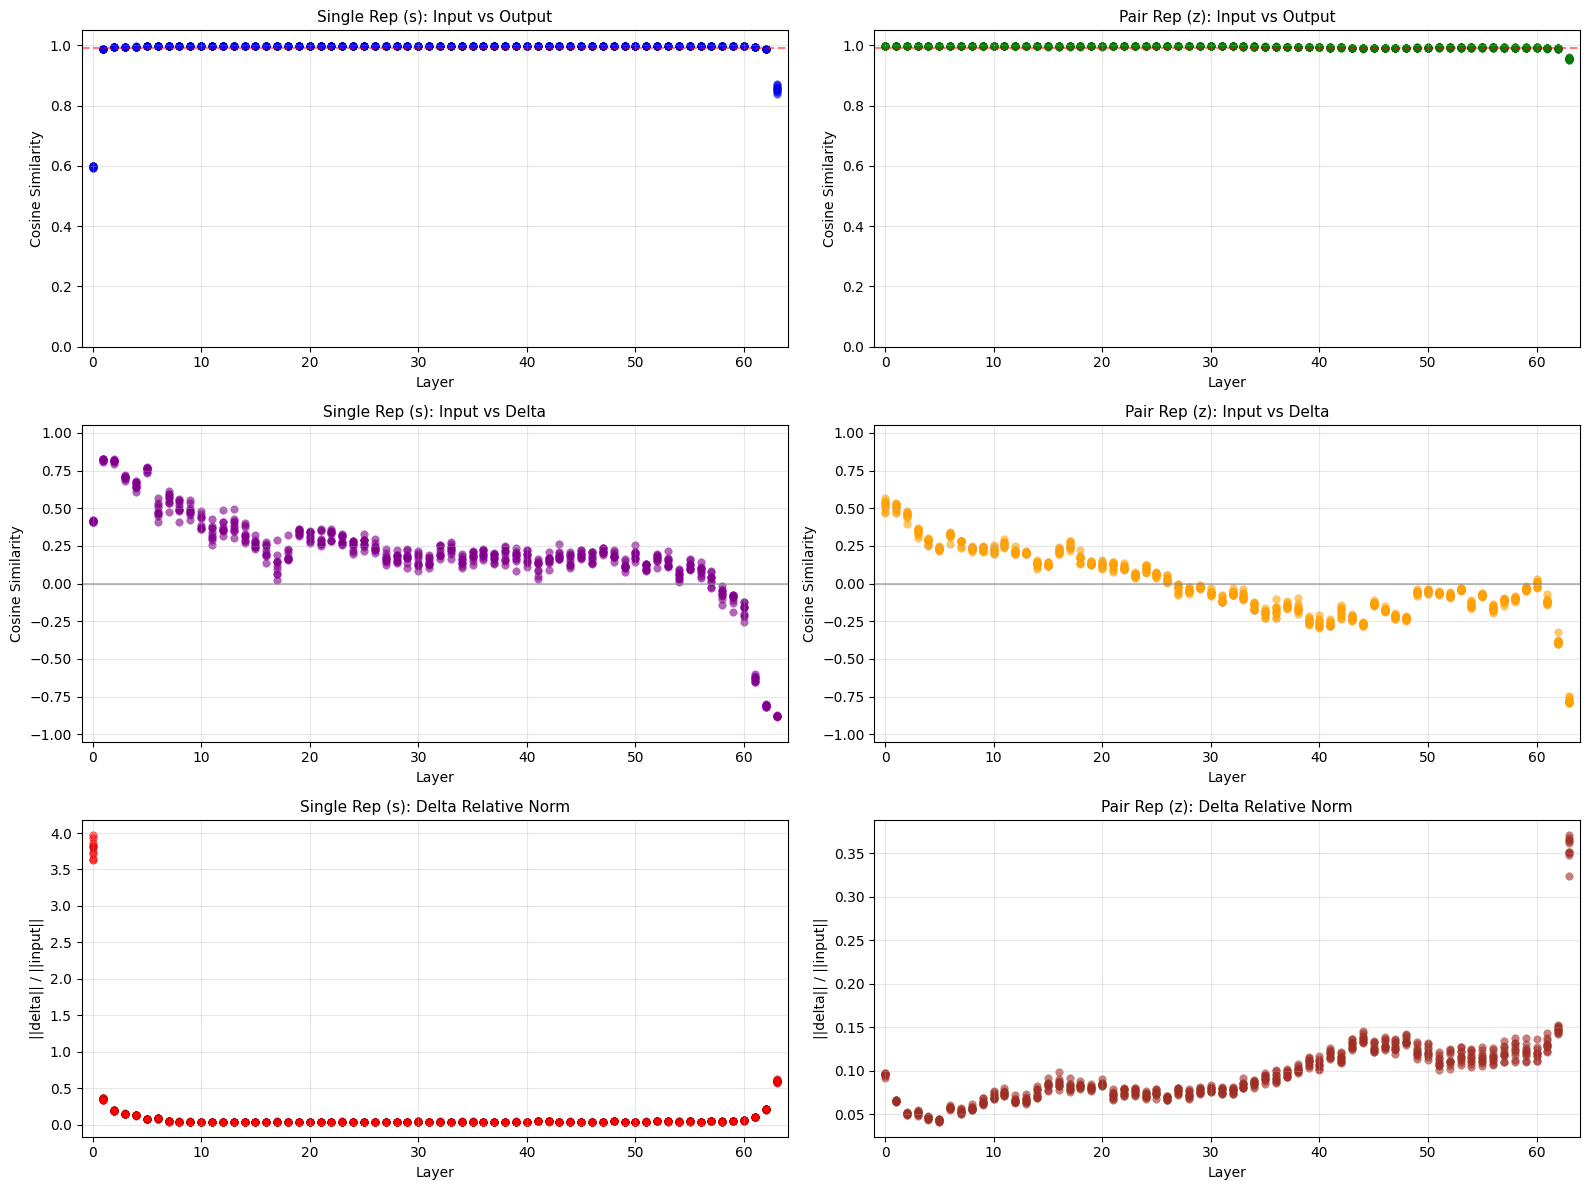


DETAILED LAYER STATISTICS
Layer  s_IO_sim   z_IO_sim   s_ID_sim   z_ID_sim   s_norm     z_norm    
----------------------------------------------------------------------------------------------------
0      0.5974     0.9970     0.4142     0.5189     3.7926     0.0959    
1      0.9881     0.9985     0.8207     0.5053     0.3515     0.0655    
2      0.9952     0.9990     0.8126     0.4527     0.1945     0.0510    
3      0.9955     0.9989     0.7041     0.3434     0.1483     0.0519    
4      0.9958     0.9990     0.6503     0.2776     0.1309     0.0461    
5      0.9989     0.9991     0.7592     0.2320     0.0763     0.0432    
6      0.9974     0.9986     0.4874     0.3187     0.0868     0.0577    
7      0.9994     0.9987     0.5613     0.2740     0.0446     0.0531    
8      0.9994     0.9985     0.5073     0.2316     0.0416     0.0570    
9      0.9994     0.9981     0.4856     0.2303     0.0394     0.0645    
10     0.9994     0.9977     0.4117     0.2210     0.0378     0.0712 

In [13]:
# Create visualization
if model is not None and 'all_metrics' in dir():
    plot_all_metrics(all_metrics)
    print_layer_statistics(all_metrics)
else:
    print("Run the analysis first to generate the plots.")

## Layer Importance Ranking

Rank layers by their contribution (lower similarity = more transformation = more important)

In [14]:
def rank_layers_by_importance(
    all_metrics: List[Dict[int, LayerMetrics]],
):
    """Rank layers by their importance based on multiple metrics.
    
    Layers with small deltas (low relative norm) and high input-output similarity 
    are candidates for removal.
    """
    num_layers = max(max(d.keys()) for d in all_metrics) + 1
    
    # Compute mean metrics per layer
    layer_stats = {}
    for layer_idx in range(num_layers):
        layer_metrics = [d[layer_idx] for d in all_metrics]
        
        layer_stats[layer_idx] = {
            's_io_sim': np.mean([m.s_input_output_sim for m in layer_metrics]),
            'z_io_sim': np.mean([m.z_input_output_sim for m in layer_metrics]),
            's_id_sim': np.mean([m.s_input_delta_sim for m in layer_metrics]),
            'z_id_sim': np.mean([m.z_input_delta_sim for m in layer_metrics]),
            's_norm': np.mean([m.s_delta_relative_norm for m in layer_metrics]),
            'z_norm': np.mean([m.z_delta_relative_norm for m in layer_metrics]),
        }
    
    # Rank by delta relative norm (smallest = least important)
    # Low norm means small update relative to input
    ranked_by_s_norm = sorted(layer_stats.items(), key=lambda x: x[1]['s_norm'])
    ranked_by_z_norm = sorted(layer_stats.items(), key=lambda x: x[1]['z_norm'])
    
    # Combined ranking: average of s and z delta norms
    combined_norms = {idx: (stats['s_norm'] + stats['z_norm']) / 2 
                      for idx, stats in layer_stats.items()}
    ranked_by_combined_norm = sorted(combined_norms.items(), key=lambda x: x[1])
    
    print("\n" + "="*90)
    print("LAYER RANKING BY DELTA RELATIVE NORM (smallest delta = candidate for removal)")
    print("="*90)
    print(f"{'Rank':<6} {'Layer':<8} {'Combined':<12} {'s_norm':<12} {'z_norm':<12} {'s_IO_sim':<12} {'z_IO_sim':<12}")
    print("-"*90)
    
    for rank, (layer_idx, combined_norm) in enumerate(ranked_by_combined_norm, 1):
        stats = layer_stats[layer_idx]
        print(f"{rank:<6} {layer_idx:<8} {combined_norm:<12.4f} {stats['s_norm']:<12.4f} {stats['z_norm']:<12.4f} "
              f"{stats['s_io_sim']:<12.4f} {stats['z_io_sim']:<12.4f}")
    
    # Identify potential candidates for removal (small delta norm)
    print("\n" + "="*90)
    print("POTENTIAL REMOVAL CANDIDATES")
    print("="*90)
    
    # Find layers where both s and z have small relative norms
    threshold_percentile = 25  # bottom 25%
    s_threshold = np.percentile([s['s_norm'] for s in layer_stats.values()], threshold_percentile)
    z_threshold = np.percentile([s['z_norm'] for s in layer_stats.values()], threshold_percentile)
    
    candidates = [idx for idx, stats in layer_stats.items() 
                  if stats['s_norm'] < s_threshold or stats['z_norm'] < z_threshold]
    
    print(f"Layers with delta norm in bottom {threshold_percentile}% for s or z:")
    print(f"  s threshold: {s_threshold:.4f}, z threshold: {z_threshold:.4f}")
    print(f"  Candidates: {sorted(candidates)}")
    
    return ranked_by_combined_norm, layer_stats

## Analysis with Realistic YAML (Nanobody Design)

Now let's run the same analysis with a realistic nanobody design specification.

In [15]:
# Run analysis with the nanobody example
if model is not None and NANOBODY_YAML.exists():
    nanobody_metrics = run_analysis_with_yamls(
        model,
        yaml_paths=[NANOBODY_YAML],
        moldir=MOLDIR,
        device=DEVICE,
        recycling_steps=3,
    )
    print("\nNanobody analysis complete!")
else:
    print("Model not loaded or YAML not found.")

Running analysis with 1 YAML files...
Registered hooks on 64 pairformer layers

Removing leading and/or trailing unresolved residues from included part of chain B in /home/bizon/git/boltzgen-train-experiments/example/nanobody/9bkq-assembly2.cif.
  Leading unresolved:  SER,ALA
  Trailing unresolved: 


Processing sample 1/1: penguinpox.yaml
  Sequence length: 327 tokens


  Input-Output sim:  s=[0.6061, 0.9994], z=[0.8401, 0.9991]
  Delta rel. norm:   s=[0.0350, 4.1766], z=[0.0426, 0.5424]

Nanobody analysis complete!


NANOBODY DESIGN ANALYSIS RESULTS


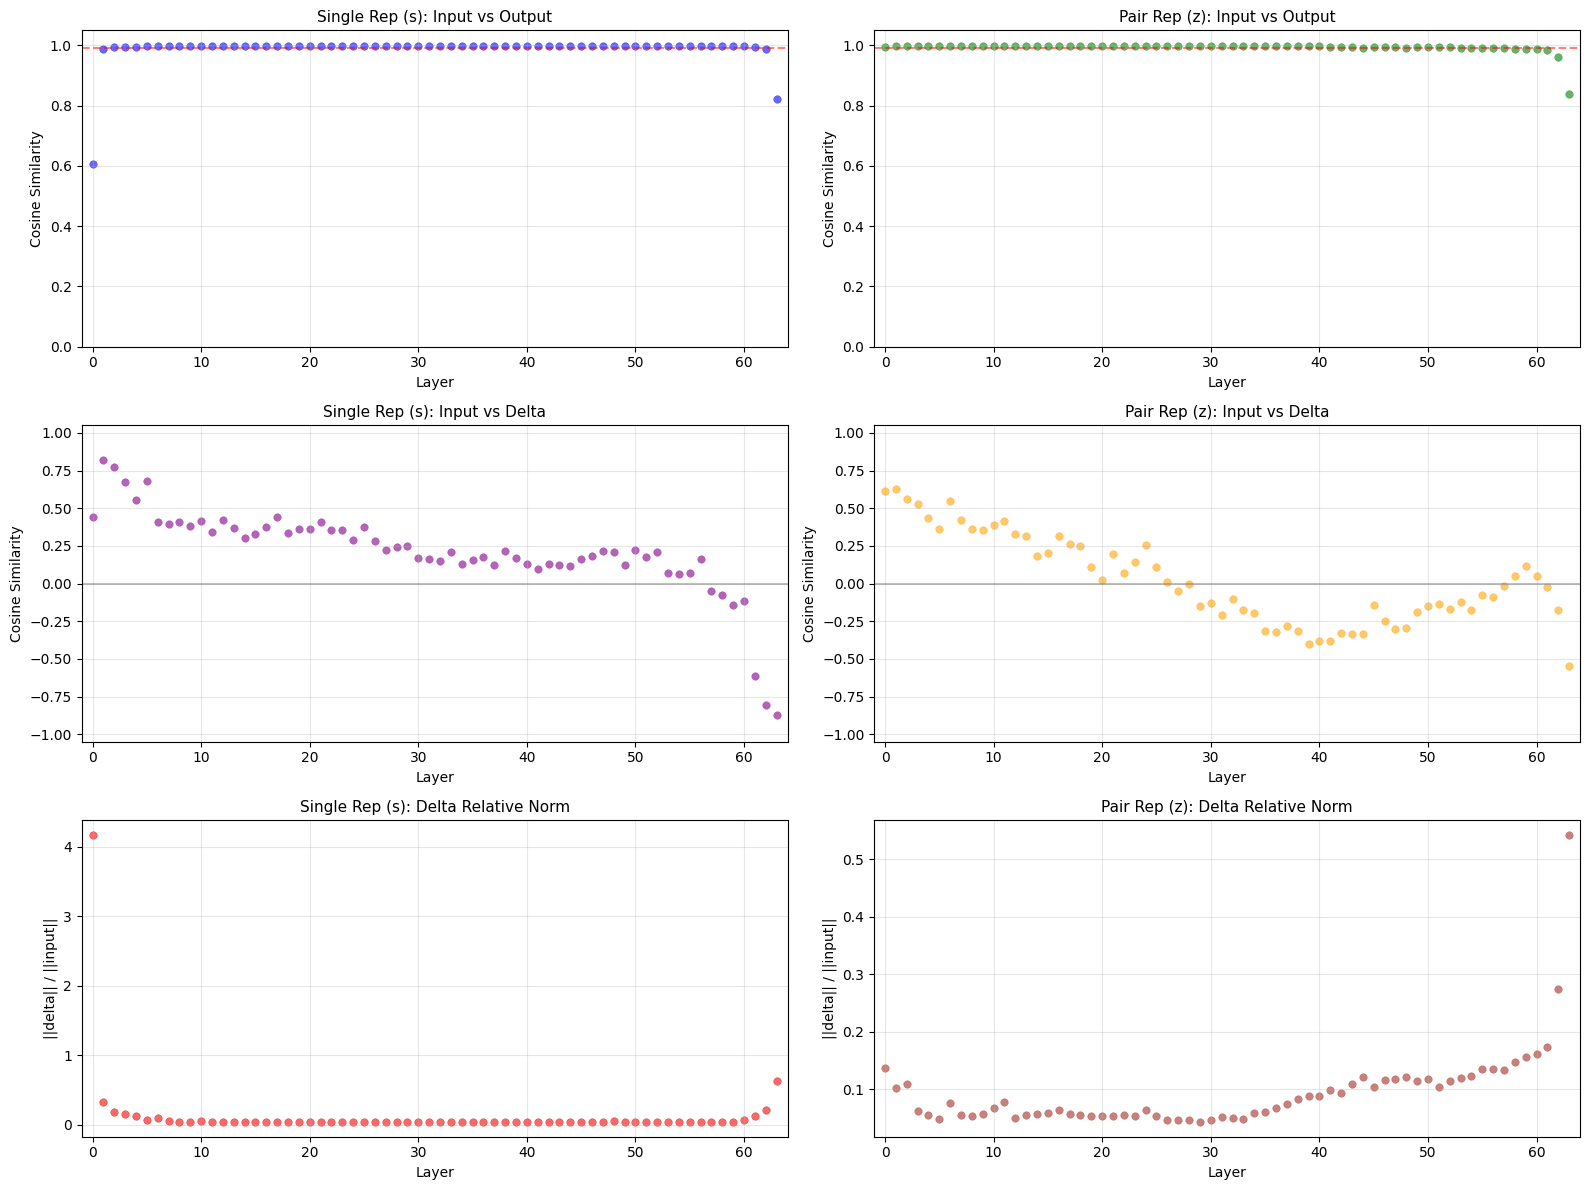


LAYER RANKING BY DELTA RELATIVE NORM (smallest delta = candidate for removal)
Rank   Layer    Combined     s_norm       z_norm       s_IO_sim     z_IO_sim    
------------------------------------------------------------------------------------------
1      29       0.0389       0.0351       0.0426       0.9994       0.9991      
2      27       0.0409       0.0352       0.0466       0.9994       0.9989      
3      28       0.0415       0.0370       0.0459       0.9994       0.9989      
4      30       0.0419       0.0374       0.0465       0.9993       0.9989      
5      26       0.0421       0.0375       0.0466       0.9994       0.9989      
6      33       0.0422       0.0367       0.0478       0.9994       0.9989      
7      32       0.0431       0.0367       0.0495       0.9993       0.9988      
8      31       0.0438       0.0350       0.0525       0.9994       0.9987      
9      25       0.0456       0.0380       0.0531       0.9994       0.9986      
10     20       0.04

In [16]:
# Visualize nanobody results
if 'nanobody_metrics' in dir() and nanobody_metrics:
    print("="*80)
    print("NANOBODY DESIGN ANALYSIS RESULTS")
    print("="*80)
    plot_all_metrics(nanobody_metrics)
    
    # Also run ranking
    nanobody_ranking, nanobody_layer_stats = rank_layers_by_importance(nanobody_metrics)
else:
    print("Run the nanobody analysis first.")

In [17]:
# Rank layers
if model is not None and 'all_metrics' in dir():
    ranking, layer_stats = rank_layers_by_importance(all_metrics)
else:
    print("Run the analysis first to generate rankings.")


LAYER RANKING BY DELTA RELATIVE NORM (smallest delta = candidate for removal)
Rank   Layer    Combined     s_norm       z_norm       s_IO_sim     z_IO_sim    
------------------------------------------------------------------------------------------
1      7        0.0488       0.0446       0.0531       0.9994       0.9987      
2      8        0.0493       0.0416       0.0570       0.9994       0.9985      
3      12       0.0511       0.0364       0.0658       0.9994       0.9980      
4      9        0.0520       0.0394       0.0645       0.9994       0.9981      
5      13       0.0520       0.0374       0.0666       0.9994       0.9979      
6      14       0.0545       0.0345       0.0745       0.9995       0.9973      
7      10       0.0545       0.0378       0.0712       0.9994       0.9977      
8      11       0.0546       0.0346       0.0745       0.9995       0.9975      
9      21       0.0547       0.0372       0.0722       0.9994       0.9975      
10     26       0.05